# Summarizer Evaluation Notebook

This notebook evaluates different summarization models on a subset of the training dataset.
The evaluation metrics are Faithfulness, Relevance, Coherence, Conciseness, and Language Consistency,
provided by a GPT-based `SummarizationJudge`.

## 1. Imports and Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import time
import matplotlib.pyplot as plt

# Load environment variables (e.g., OPENAI_API_KEY)
load_dotenv()

# Import summarizers
from summarizers.light import FastSummarizer, SumyTextRankSummarizer, TFIDFSummarizer
from summarizers.balanced import BartLargeSummarizer, MT5, Qwen, NeuralTextRank
# Import the judge
from judge import SummarizationJudge, SummarizationScore

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dortenenboim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


c:\repos\search-summaries\.venv\Lib\site-packages


c:\repos\search-summaries\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration

In [41]:
DATASET_PATH = 'dataset/unified_dataset.csv'
TEXT_COLUMN = 'text'
LANGUAGE_COLUMN = 'language'
MAX_SENTENCES_SUMMARY = 5
N_SAMPLES = 15
TARGET_LANGUAGES = ['english', 'german', 'arabic', 'chinese', 'spanish', 'french']

## 3. Load Data

In [42]:
try:
    df_full = pd.read_csv(DATASET_PATH)
    print(f"Dataset loaded successfully. Shape: {df_full.shape}")
    print(f"Available languages: {df_full[LANGUAGE_COLUMN].unique()}")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    df_full = pd.DataFrame() # Create empty df to avoid further errors


Dataset loaded successfully. Shape: (202, 7)
Available languages: ['english' 'spanish' 'french' 'german' 'chinese' 'arabic']


In [43]:
# remove rows that their length is more than 5K
df_full = df_full[df_full['length'] < 5000]
print(f"Filtered dataset shape: {df_full.shape}")

Filtered dataset shape: (96, 7)


## 4. Sample Data

We need to select `N_SAMPLES` (20) from the dataset, ensuring at least one sample from each of the `TARGET_LANGUAGES`.

In [44]:
# Ensure all target languages are present in the dataset
available_target_languages = [lang for lang in TARGET_LANGUAGES if lang in df_full[LANGUAGE_COLUMN].unique()]
print(f"Target languages available in dataset: {available_target_languages}")

sampled_dfs = []
# Get at least one sample from each available target language
for lang in available_target_languages:
    lang_sample = df_full[df_full[LANGUAGE_COLUMN] == lang].sample(n=1, random_state=42)
    sampled_dfs.append(lang_sample)

df_sampled_langs = pd.concat(sampled_dfs)

remaining_samples_needed = N_SAMPLES - len(df_sampled_langs)

if remaining_samples_needed > 0:
    # Get remaining samples from the rest of the dataset, excluding already sampled rows
    df_remaining_pool = df_full.drop(df_sampled_langs.index)
    if len(df_remaining_pool) >= remaining_samples_needed:
        df_additional_samples = df_remaining_pool.sample(n=remaining_samples_needed, random_state=42)
        df_eval = pd.concat([df_sampled_langs, df_additional_samples])
    else:
        # If not enough unique samples left, take all available
        df_eval = pd.concat([df_sampled_langs, df_remaining_pool])
        print(f"Warning: Could only sample {len(df_eval)} rows due to data constraints.")
elif N_SAMPLES < len(df_sampled_langs): # If we sampled more than N_SAMPLES because we have many target_languages
    df_eval = df_sampled_langs.sample(n=N_SAMPLES, random_state=42)
else: # Exactly N_SAMPLES were sampled, or N_SAMPLES == len(available_target_languages)
    df_eval = df_sampled_langs

print(f"Selected {len(df_eval)} samples for evaluation.")
print("Language distribution in selected samples:")
print(df_eval[LANGUAGE_COLUMN].value_counts())

Target languages available in dataset: ['english', 'german', 'arabic', 'chinese', 'spanish', 'french']
Selected 15 samples for evaluation.
Language distribution in selected samples:
language
english    7
chinese    3
german     2
arabic     1
spanish    1
french     1
Name: count, dtype: int64


In [62]:
df_eval = df_full

## 5. Initialize Summarizers and Judge

In [63]:
# Initialize summarizers
# fast_summarizer = FastSummarizer()
sumy_text_rank = SumyTextRankSummarizer("text_rank")
sumy_random = SumyTextRankSummarizer("random")
sumy_lsa = SumyTextRankSummarizer("lsa")
# tf_idf_summarizer = TFIDFSummarizer()
# bart_summarizer = BartLargeSummarizer()
# mt5 = MT5()
# qwen = Qwen()
# neural_textrank = NeuralTextRank()

summarizers = {
    "sumy_text_rank": sumy_text_rank,
    "sumy_random": sumy_random,
    "sumy_lsa": sumy_lsa,
    # "fast": fast_summarizer,
    # "tf-idf": tf_idf_summarizer,
    # "bart_summarizer": bart_summarizer,
    # "mt5": mt5,
    # "qwen": qwen,
    # "neural_text_rank": neural_textrank,
}

# Initialize the judge
# Assumes OPENAI_API_KEY is in .env or environment variables
try:
    judge = SummarizationJudge(model = "gpt-4.1-mini-2025-04-14")
    print("SummarizationJudge initialized.")
except Exception as e:
    print(f"Error initializing SummarizationJudge: {e}. Make sure OPENAI_API_KEY is set.")
    judge = None

SummarizationJudge initialized.


## 6. Evaluation Loop

Iterate through each row in the sampled dataset, apply each summarizer, and evaluate the results.

In [64]:
results = []



for index, row in df_eval.iterrows():
    original_text = str(row[TEXT_COLUMN])
    language = str(row[LANGUAGE_COLUMN])
    
    print(f"\nProcessing sample from row {row.name} (Language: {language})...") # Using row.name for original index

    if not original_text.strip():
        print(f"Skipping sample from row {row.name} due to empty original text.")
        continue

    for summarizer_name, summarizer_instance in summarizers.items():
        print(f"  Applying {summarizer_name}...")
        try:
            start_time = time.time()
            # Ensure the summarizer's summarize method matches expected signature
            if hasattr(summarizer_instance, 'summarize'):
                summary = summarizer_instance.summarize(
                    text=original_text, 
                    lang=language, 
                    max_sentences=MAX_SENTENCES_SUMMARY,
                    should_filter=True
                )
            else:
                print(f"    Error: {summarizer_name} does not have a 'summarize' method or signature mismatch.")
                summary = "Error: Summarizer method issue."
            
            end_time = time.time()
            latency_seconds = end_time - start_time
            print(f"    {summarizer_name} latency: {latency_seconds:.4f} seconds")

            if not summary.strip():
                print(f"    {summarizer_name} produced an empty summary.")
                scores = SummarizationScore(faithfulness=1, recall=1, precision=1, readability_clarity=1, coherence_logical_flow=1, language_consistency=False)
            else:
                print(f"    Evaluating {summarizer_name} summary...")
                scores = judge.evaluate_summary(
                    original_markdown=original_text,
                    summary=summary,
                    language=language
                )
            
            results.append({
                "sample_original_index": row.name, # Store original index
                "url": row['url'],
                "language": language,
                "summarizer": summarizer_name,
                "original_text": original_text,
                # "original_text_preview": original_text[:100] + "...", 
                "original_text_length": len(original_text),
                "summary": summary,
                "summary_length": len(summary),
                "faithfulness": scores.faithfulness,
                "recall": scores.recall,
                "precision": scores.precision,
                "readability_clarity": scores.readability_clarity,
                "coherence_logical_flow": scores.coherence_logical_flow,
                "language_consistency": int(scores.language_consistency),
                "latency_seconds": latency_seconds
            })
            print(f"    Scores for {summarizer_name}: F={scores.faithfulness}, R={scores.recall}, P={scores.precision}, Read={scores.readability_clarity}, COHER={scores.coherence_logical_flow} ,LC={scores.language_consistency}")

        except Exception as e:
            print(f"    Error during summarization or evaluation with {summarizer_name} for sample {row.name}: {e}")
            raise e
            results.append({
                "sample_original_index": row.name,
                "language": language,
                "summarizer": summarizer_name,
                "original_text_preview": original_text[:100] + "...",
                "original_text_length": len(original_text),
                "summary": f"Error: {e}",
                "faithfulness": 1,
                "recall": 1,
                "precision": 1,
                "readability_clarity": 1,
                "coherence_logical_flow": 1,
                "language_consistency": False,
                "latency_seconds": -1
            })


Processing sample from row 9 (Language: english)...
  Applying sumy_text_rank...
random
    sumy_text_rank latency: 0.0180 seconds
    Evaluating sumy_text_rank summary...
    Scores for sumy_text_rank: F=5, R=3, P=4, Read=4, COHER=3 ,LC=True
  Applying sumy_random...
random
    sumy_random latency: 0.0000 seconds
    Evaluating sumy_random summary...
    Scores for sumy_random: F=4, R=2, P=3, Read=3, COHER=3 ,LC=True
  Applying sumy_lsa...
random
    sumy_lsa latency: 0.0096 seconds
    Evaluating sumy_lsa summary...
    Scores for sumy_lsa: F=5, R=3, P=4, Read=4, COHER=4 ,LC=True

Processing sample from row 10 (Language: english)...
  Applying sumy_text_rank...
random
    sumy_text_rank latency: 0.0023 seconds
    Evaluating sumy_text_rank summary...
    Scores for sumy_text_rank: F=4, R=2, P=4, Read=4, COHER=4 ,LC=True
  Applying sumy_random...
random
    sumy_random latency: 0.0000 seconds
    Evaluating sumy_random summary...
    Scores for sumy_random: F=5, R=2, P=3, Read=4, COH

## 7. Display Results

In [65]:
df_results = pd.DataFrame(results)
# print("\nEvaluation Results:")
# display(df_results) 

# %% [markdown]
# ### Average Scores per Summarizer

# %%
# Calculate average scores, ensuring numeric conversion for score columns
score_cols = ['faithfulness', 'recall', 'precision', 'coherence_logical_flow', 'coherence_logical_flow','language_consistency', 'latency_seconds']
for col in score_cols:
    df_results[col] = pd.to_numeric(df_results[col], errors='coerce')

avg_scores = df_results.groupby('summarizer')[score_cols].mean()
print("\nAverage Scores per Summarizer:")
display(avg_scores)

# %% [markdown]
# ### Average Scores per Language

# %%
avg_scores_lang = df_results.groupby(['language', 'summarizer'])[score_cols].mean()
print("\nAverage Scores per Language and Summarizer:")
display(avg_scores_lang)

# summary_length per summarizer
avg_summary_length = df_results.groupby('summarizer')['summary_length'].mean()
print("\nAverage Summary Length per Summarizer:")
display(avg_summary_length)




Average Scores per Summarizer:


,faithfulness,recall,precision,coherence_logical_flow,coherence_logical_flow,language_consistency,latency_seconds
summarizer,,,,,,,
sumy_lsa,4.625000,3.041667,3.937500,3.854167,3.854167,0.979167,0.020763
sumy_random,4.291667,2.437500,3.729167,3.489583,3.489583,0.979167,0.004000
sumy_text_rank,4.500000,2.979167,3.708333,3.656250,3.656250,0.979167,0.020466



Average Scores per Language and Summarizer:


faithfulness    recall  precision  \
language summarizer                                          
arabic   sumy_lsa            4.625000  3.000000   3.125000   
         sumy_random         3.625000  2.250000   2.750000   
         sumy_text_rank      4.500000  2.750000   3.375000   
chinese  sumy_lsa            4.619048  3.095238   4.571429   
         sumy_random         4.619048  3.000000   4.523810   
         sumy_text_rank      4.619048  3.285714   4.428571   
english  sumy_lsa            4.581395  3.093023   3.767442   
         sumy_random         4.116279  2.279070   3.558140   
         sumy_text_rank      4.348837  2.930233   3.581395   
french   sumy_lsa            5.000000  2.000000   4.000000   
         sumy_random         5.000000  2.000000   4.000000   
         sumy_text_rank      4.000000  2.000000   2.000000   
german   sumy_lsa            4.687500  3.000000   3.937500   
         sumy_random         4.500000  2.187500   3.500000   
         sumy_text_rank      4.562500  2.750000   3.187500   
spanish  sumy_lsa            4.714286  2.857143   4.000000   
         sumy_random         4.571429  2.571429   4.000000   
         sumy_text_rank      5.000000  3.285714   4.142857   

                         coherence_logical_flow  coherence_logical_flow  \
language summarizer                                                       
arabic   sumy_lsa                      3.125000                3.125000   
         sumy_random                   2.625000                2.625000   
         sumy_text_rank                3.500000                3.500000   
chinese  sumy_lsa                      4.476190                4.476190   
         sumy_random                   4.333333                4.333333   
         sumy_text_rank                4.523810                4.523810   
english  sumy_lsa                      3.837209                3.837209   
         sumy_random                   3.209302                3.209302   
         sumy_text_rank                3.395349                3.395349   
french   sumy_lsa                      4.000000                4.000000   
         sumy_random                   4.000000                4.000000   
         sumy_text_rank                3.000000                3.000000   
german   sumy_lsa                      3.625000                3.625000   
         sumy_random                   3.625000                3.625000   
         sumy_text_rank                3.125000                3.125000   
spanish  sumy_lsa                      3.428571                3.428571   
         sumy_random                   3.285714                3.285714   
         sumy_text_rank                4.142857                4.142857   

                         language_consistency  latency_seconds  
language summarizer                                             
arabic   sumy_lsa                    1.000000         0.012678  
         sumy_random                 1.000000         0.000773  
         sumy_text_rank              1.000000         0.014747  
chinese  sumy_lsa                    0.904762         0.031520  
         sumy_random                 0.904762         0.009125  
         sumy_text_rank              0.904762         0.037667  
english  sumy_lsa                    1.000000         0.022146  
         sumy_random                 1.000000         0.003508  
         sumy_text_rank              1.000000         0.017830  
french   sumy_lsa                    1.000000         0.008185  
         sumy_random                 1.000000         0.000000  
         sumy_text_rank              1.000000         0.015992  
german   sumy_lsa                    1.000000         0.012357  
         sumy_random                 1.000000         0.001669  
         sumy_text_rank              1.000000         0.011137  
spanish  sumy_lsa                    1.000000         0.010255  
         sumy_random                 1.000000         0.001238  
         sumy_text_rank              1.000000   


Average Summary Length per Summarizer:


summarizer
sumy_lsa          694.343750
sumy_random       472.958333
sumy_text_rank    746.843750
Name: summary_length, dtype: float64

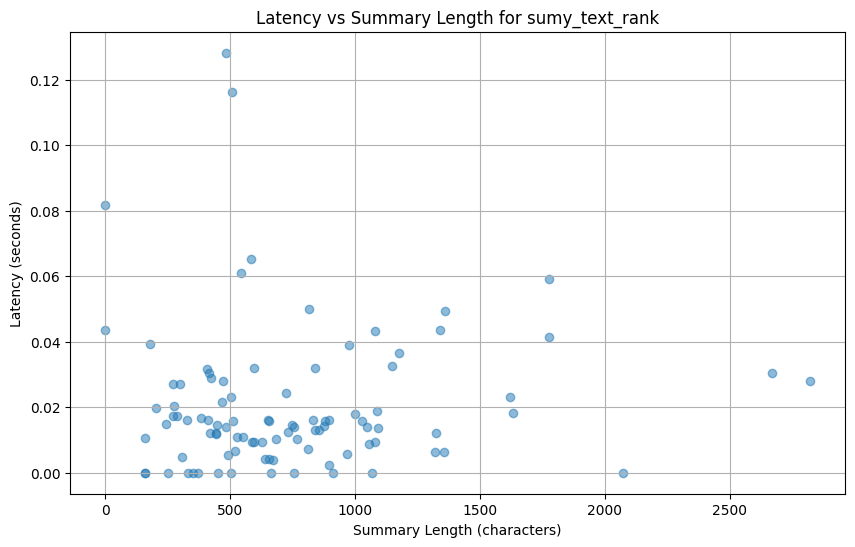

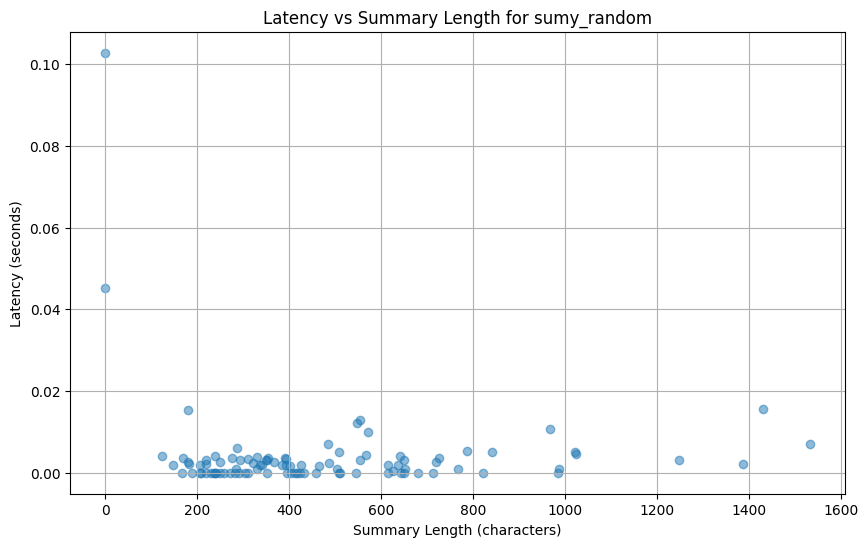

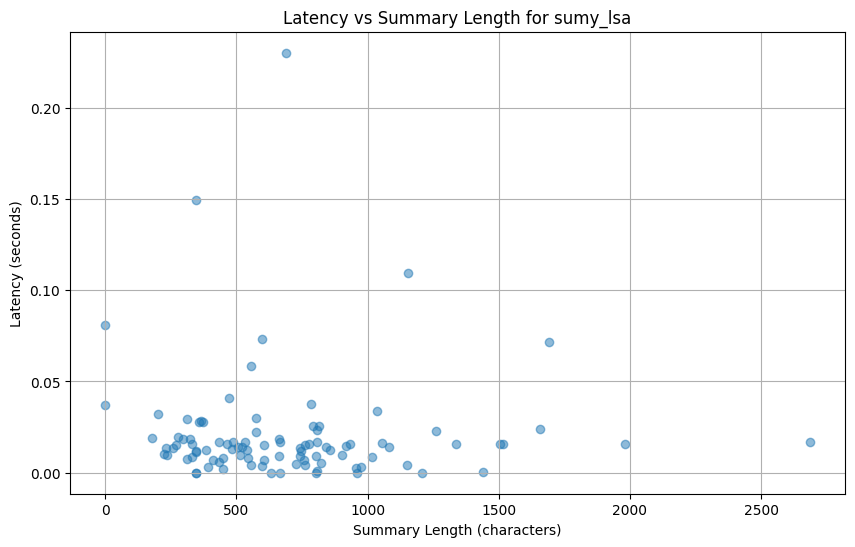

In [66]:
# for each summarizer, show latency as function of summary length
for summarizer in df_results['summarizer'].unique():
    df_summarizer = df_results[df_results['summarizer'] == summarizer]
    plt.figure(figsize=(10, 6))
    plt.scatter(df_summarizer['summary_length'], df_summarizer['latency_seconds'], alpha=0.5)
    plt.title(f"Latency vs Summary Length for {summarizer}")
    plt.xlabel("Summary Length (characters)")
    plt.ylabel("Latency (seconds)")
    plt.grid()
    plt.show()

In [67]:
# save results to CSV
output_path = 'evaluation_results.csv'
df_results.to_csv(output_path, index=False)

## End of Evaluation